# Importing Packages Needed

In [53]:
import numpy as np

In [54]:
import scipy as sp

In [55]:
import matplotlib.pyplot as py

In [56]:
from scipy.optimize import curve_fit

In [57]:
from scipy.signal import find_peaks

In [58]:
import collections as col

# Definition of Named Tuples

In [59]:
component = col.namedtuple('component','phase intensity')

In [60]:
ind_sub = col.namedtuple('ind_sub','phase intensity width')

In [61]:
pulse_sub = col.namedtuple('pulse_sub','frequency sub1 sub2, errors')

In [62]:
sub_separation = col.namedtuple('sub_separation','frequency separation')

# Definition of Functions

In [63]:
def chsq(observed_values, expected_values, err):
    """
    Chi Squared operation:
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

In [64]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Sigma clipping operation:
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Keegan Smith
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

Gaussian Fitting Functions:

In [65]:
"""
Definitions of gaussian equations - single, double and triple
"""

def gauss(x,cen,sd,amp):
    return amp*np.exp(-(x-cen)**2/2/sd**2)

def twogauss(x,cen1,sd1,amp1,cen2,sd2,amp2):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)

def threegauss(x,cen1,sd1,amp1,cen2,sd2,amp2,cen3,sd3,amp3):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)+gauss(x,cen3,sd3,amp3)

In [66]:
"""
Fitting data into the above gaussian equations. 

Parameters:
    -----------
    x,y: list, list
        A list of floats - the data 
    error: float
        The error across all data - standard deviation of the noise
    expect: list
        The expected parameters for the gaussian equation

    Returns:
    --------
    params: list
        The parameters (x, cen, sd) of the fit
    cov: list
        The covariance of the fit
    fit: list
        The y data of the actual fit (parameters have been put back into the equation)
    chi: float
        The chi squared value
"""

def single_fit(x, y, error, expect):
    params,cov=curve_fit(gauss,x,y,expect,bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,np.inf]))
    fit=gauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-1)
        
    return params, cov, fit, chi

def double_fit(x, y, error, expect):
    params,cov=curve_fit(twogauss,x,y,expect,bounds=([-np.inf,-np.inf,0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    fit=twogauss(x,*params)

    chi=chsq(y, fit, error)
    chir=chi/(len(y)-1)
    
    return params, cov, fit, chi

def triple_fit(x, y, error, expect):
    params,cov=curve_fit(threegauss,x,y,expect,bounds=([-np.inf,-np.inf,0,-np.inf,-np.inf,0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    fit=threegauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-1)
    
    return params, cov, fit, chi

In [67]:
"""
def finding_single_fit(x,y, error):
    
    status=100
    
    expect=[500,75,50]
    try:
        params1, cov1, fit1, chi1 = single_fit(x, y, error, expect)
    except:
        chi1=np.inf
        diff1=np.inf
    
    expect.extend((750,75,50))
    try:
        params2, cov2, fit2, chi2 = double_fit(x, y, error, expect)
    except:
        chi2=np.inf
        diff2=np.inf

    if chi1<=chi2 and chi1!=np.inf: 
        status=1

    elif chi2<=chi1 and chi2!=np.inf:
        status=2
        
    if chi1==np.inf and chi2==np.inf: 
        status=0
    
    return status
    
"""

'\ndef finding_single_fit(x,y, error):\n    \n    status=100\n    \n    expect=[500,75,50]\n    try:\n        params1, cov1, fit1, chi1 = single_fit(x, y, error, expect)\n    except:\n        chi1=np.inf\n        diff1=np.inf\n    \n    expect.extend((750,75,50))\n    try:\n        params2, cov2, fit2, chi2 = double_fit(x, y, error, expect)\n    except:\n        chi2=np.inf\n        diff2=np.inf\n\n    if chi1<=chi2 and chi1!=np.inf: \n        status=1\n\n    elif chi2<=chi1 and chi2!=np.inf:\n        status=2\n        \n    if chi1==np.inf and chi2==np.inf: \n        status=0\n    \n    return status\n    \n'

In [68]:
"""
    Fitting Gaussians operation:
    Creates the best fit for the data out of the above mentioned gaussian equations.
    First attempts a double fit, and if this fails it then attempts a single fit. If this also fails create a no fit.
    
    Then checks if a double fit is created, the chi value and if over 1100, replaces it with a single fit instead. 
    If chi of a single fit is still above 1100 then replaces it with a no fit. 

    Parameters:
    -----------
    x, y: list, list
        A list of floats - the data 
    error: float
        The error across all data - standard deviation of the noise
        
    Returns:
    --------
    fit: list
        The y data of the best fit 
    params: list
        The parameters (x, cen, sd) of the best fit
    sigma: list
        List of the errors in the parameters
    chi: float
        The chi squared value
""" 

def fitting_gaussians(x,y, error):
    py.plot(x,y,lw=0.1)
    
    fitting = 5
    
    try:
        expect=[500,75,50,750,75,50]
        params, cov, fit, chi = double_fit(x, y, error, expect)
        sigma=np.sqrt(np.diag(cov))
        py.plot(x,fit, color='green')
        fitting =2
    except:
        try:
            expect=[500,75,50]
            params, cov, fit, chi = single_fit(x, y, error, expect)
            sigma=np.sqrt(np.diag(cov))
            py.plot(x,fit, color='red')
            fitting=1
        except:
            params=0
            cov=0
            fit=[]
            chi=np.inf
            sigma=0
            fitting=0
            
    if (fitting==2 and chi>1100):
        try:
            expect=[500,75,50]
            params, cov, fit, chi = single_fit(x, y, error, expect)
            sigma=np.sqrt(np.diag(cov))
            py.plot(x,fit, color='red')
            fitting=1
        except:
            params=0
            cov=0
            fit=[]
            chi=np.inf
            sigma=0
            fitting=0
        
    if chi>1100 and chi!=np.inf:
        params=0
        cov=0
        fit=[]
        chi=np.inf
        sigma=0
        fitting=0
        
    return fit, params, sigma, chi

Finding Peak of Fittings Function

In [69]:
def gauss_peaks(fit, nofreqband, freqband, sigma):
    component1=0
    component2=0   
    i=0
    j=0
    
    freq=(((500-300)/nofreqband)*(nofreqband-freqband))+300

    peakpos = find_peaks(fit, prominence=0.2)[0]
    print(peakpos)
    
    if len(peakpos) == 2:
        if peakpos[0]>=200 and peakpos[0]<=400:
            i=1
            comp1u=((sigma[0], sigma[1], sigma[2]))
        elif peakpos[0]>=500 and peakpos[0]<=750:
            i=2
            comp2u=((sigma[0], sigma[1], sigma[2]))
        else:
            i=0
        if peakpos[1]>=200 and peakpos[1]<=400:
            j=1
            comp1u=((sigma[3], sigma[4], sigma[5]))
        elif peakpos[1]>=500 and peakpos[1]<=750:
            j=2
            comp2u=((sigma[3], sigma[4], sigma[5]))
        else:
            j=0
    elif len(peakpos) == 1:
        if (peakpos[0]>=200 and peakpos[0]<=400): 
            i=1
            comp1u=((sigma[0], sigma[1], sigma[2]))
        elif (peakpos[0]>=500 and peakpos[0]<=750):
            i=2
            comp2u=((sigma[0], sigma[1], sigma[2]))
        else:
            i=0
        j=0
    else:
        i=0
        j=0
        
    if i==1:
        component1 = component(phase=(360/1024)*peakpos[0], intensity=fit[peakpos[0]])
    elif i==2:
        component2 = component(phase=(360/1024)*peakpos[0], intensity=fit[peakpos[0]])
        
    if j==1:
        component1 = component(phase=(360/1024)*peakpos[1], intensity=fit[peakpos[1]])
    elif j==2:
        component2 = component(phase=(360/1024)*peakpos[1], intensity=fit[peakpos[1]])

    if component1==0:
        component1 = component(phase=0, intensity=0)
        comp1u=((0, 0, 0))
    if component2==0:
        component2 = component(phase=0, intensity=0)
        comp2u=((0, 0, 0))
        
    errors = (*comp1u,*comp2u)
        
    pulse_subp = pulse_sub(frequency=freq, sub1=component1, sub2=component2, errors=sigma)
        
    return pulse_subp

Plotting Fittings Functions

In [70]:
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [71]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

    return 

In [72]:
def plot_peaks(x,y,profile_comp):
    py.plot((360/1024)*x,y, lw=0.5)
    py.plot((360/1024)*x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [73]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)

In [74]:
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))

In [75]:
def linear(x, m, c):
    return (float(m)*x+c)

Extra Stuff

In [76]:
def graphing_spulse(fit_spulse,spulse_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        if spulse_num==1:
            for i in range(0,len(fit_spulse)):
                if fit_spulse[i][1][0] != 0:
                    phase_comp.append(fit_spulse[i][1][0])
                    frequency_comp.append(fit_spulse[i][0])
                    comp_err.append(fit_spulse[i][3][0])
        elif spulse_num==2:
            for i in range(0,len(fit_spulse)):
                if fit_spulse[i][2][0] != 0:
                    phase_comp.append(fit_spulse[i][2][0])
                    frequency_comp.append(fit_spulse[i][0])
                    comp_err.append(fit_spulse[i][3][3])
        
        return phase_comp, frequency_comp, comp_err    

# INDIVIDUAL FREQUENCY BAND

## Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [77]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [78]:
single_pulse = np.loadtxt(fname='../archivefiles/s_archivefiles/f256/pdv/pulse_1503960531.pdv', dtype=fulldatatype)

In [79]:
no_freq_bands = max(single_pulse['frequency'])+1

## Gaussian Fitting

Choosing Frequency Band. Following Section is for error checking:

In [80]:
freqband = 1
f = single_pulse['frequency'] == freqband

phase=single_pulse['phase'][f]
intensity=single_pulse['intensity'][f]
x = phase
y = intensity

In [81]:
len(y)

1024

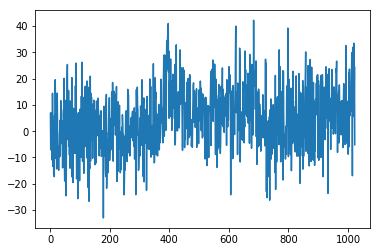

In [82]:
py.plot(x,y)

In [83]:
noise = sigmaClip(y)
error = np.nanstd(noise[1])
print(error)

11.2528875706175


Gaussian Plots

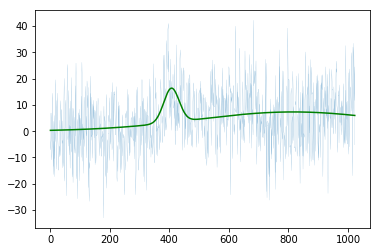

In [84]:
fit, params, sigma, chi=fitting_gaussians(x,y,error)

[407 816]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


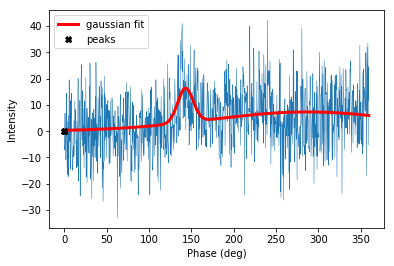

In [85]:
if fit!=[]:
    pulse_subp = gauss_peaks(fit, no_freq_bands, freqband, sigma)
    plot_peaks(x,y, pulse_subp)

# INDIVIDUAL PULSE

## Gaussian Fitting 

The following is a looped version of the previous section to find the correct peaks for each frequency profile

In [86]:
fit_spulse = []

/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


[407 816]
[396 517]
[395 539]
[394 570]
[425 733]
[392]
[389 510]
[388 485]
[439 752]
[384 679]
[382 490]
[380 555]


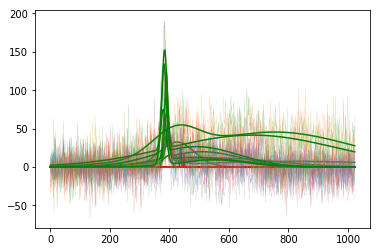

In [87]:
for i in range(no_freq_bands):
    
    freqband = i
  
    f = single_pulse['frequency'] == freqband

    x=single_pulse['phase'][f]
    y=single_pulse['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])
    
    fit, params, sigma, chi=fitting_gaussians(x,y,error)
        
    if fit!=[]:
        pulse_subp = gauss_peaks(fit, no_freq_bands, freqband, sigma)
        fit_spulse.append(pulse_subp)
    

# Change of Peak Position over Frequency

## Fit Peaks (fit_components)

Starting to graph out all the movement of component phase across frequency

---



In [88]:
fit_spulse

[pulse_sub(frequency=486.6666666666667, sub1=component(phase=0, intensity=0), sub2=component(phase=0, intensity=0), errors=array([ 4.51822736,  4.85274563,  2.02199139, 62.76421182, 61.73187009,
        0.58865757])),
 pulse_sub(frequency=473.33333333333337, sub1=component(phase=139.21875, intensity=36.20747933534053), sub2=component(phase=181.7578125, intensity=9.453292560555614), errors=array([ 1.35434183,  1.44395351,  3.05284325, 16.34617581, 14.80860508,
        0.8948078 ])),
 pulse_sub(frequency=460.0, sub1=component(phase=138.8671875, intensity=41.94921965039786), sub2=component(phase=189.4921875, intensity=11.956732652239397), errors=array([ 0.92401111,  0.98543435,  3.26010034, 11.14170248, 10.76449233,
        0.88318958])),
 pulse_sub(frequency=446.6666666666667, sub1=component(phase=138.515625, intensity=48.40667811386133), sub2=component(phase=200.390625, intensity=11.451134999209264), errors=array([ 0.78645069,  0.81277709,  3.32642682, 13.99696994, 13.51591428,
        

In [89]:
phase_comp1, frequency_comp1, comp1_err=graphing_spulse(fit_spulse,1)

Text(0,0.5,'Frequency')

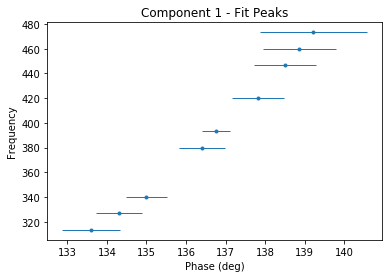

In [90]:
#py.plot(phase_comp1,frequency_comp1, '.')
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=1, label='data')
py.title('Component 1 - Fit Peaks')
py.xlabel('Phase (deg)')
py.ylabel('Frequency')

In [91]:
phase_comp2, frequency_comp2, comp2_err=graphing_spulse(fit_spulse,2)

Text(0,0.5,'Frequency')

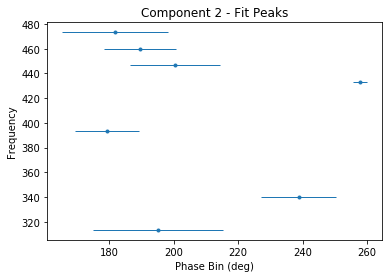

In [92]:
#py.plot(phase_comp2,frequency_comp2, '.')
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=1, label='data')
py.title('Component 2 - Fit Peaks')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

# Fitting Power Laws to Position

## Component 1

In [93]:
thorsett_params1,thorsett_cov1=curve_fit(thorsett,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
thorsett_fit_error1=np.sqrt(np.diag(thorsett_cov1))
thorsett1 = thorsett(frequency_comp1, *thorsett_params1)

In [94]:
pl_params1,pl_cov1=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
pl_fit_error1=np.sqrt(np.diag(pl_cov1))
powerlaw1 = powerlaw(frequency_comp1, *pl_params1)

In [95]:
mov_params1,mov_cov1=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
mov_fit_error1=np.sqrt(np.diag(mov_cov1))
linear1 = linear(frequency_comp1, *mov_params1)

TypeError: can't multiply sequence by non-int of type 'float'

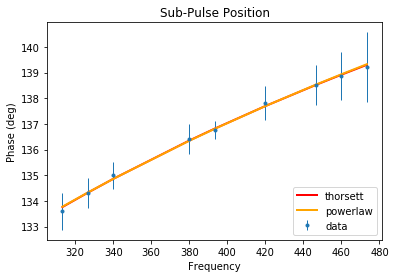

In [96]:
#py.plot(frequency_comp1,phase_comp1, '.', label='data')
py.errorbar(frequency_comp1,phase_comp1, yerr=comp1_err, fmt='.', lw=1, label='data')
py.plot(frequency_comp1,thorsett1, color='red',lw=2,label='thorsett')
py.plot(frequency_comp1,powerlaw1, color='orange',lw=2,label='powerlaw')
py.title('Sub-Pulse Position')
py.xlabel('Frequency')
py.ylabel('Phase (deg)')
py.legend(loc='lower right')

In [97]:
#chi, p = sp.stats.chisquare(phase_comp1, mov_fit1)
print(f'The thorsett equation of fit for this pulse is: \t Phase = {thorsett_params1[0]:.3f} \u03BD^{thorsett_params1[1]:.3f} + {thorsett_params1[2]:.3f} \n')
#print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')

print(f'The power law equation of fit for this pulse is: \t Phase = {pl_params1[0]:.3f} \u03BD^{pl_params1[1]:.3f} \n')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The thorsett equation of fit for this pulse is: 	 Phase = 8219.726 ν^0.002 + -8162.806 

The power law equation of fit for this pulse is: 	 Phase = 75.914 ν^0.099 

Units for Δθ is degrees and ν is MHz


## Component 2

In [ ]:
mov_params2,mov_cov2=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=100000)
mov_fit_error2=np.sqrt(np.diag(mov_cov2))

In [ ]:
print(mov_params2)
print(mov_fit_error2)
mov_fit2 = powerlaw(frequency_comp2, *mov_params2)

In [ ]:
py.plot(frequency_comp2,phase_comp2, '.', label='data')
py.plot(frequency_comp2,mov_fit2, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('Phase (deg)')

In [ ]:
chi, p = sp.stats.chisquare(phase_comp2, mov_fit2)
print(f'The equation of fit for this pulse is: \t Phase = {mov_params2[0]:.3f} \u03BD^{mov_params2[1]:.3f} + {mov_params2[2]:.3f} \n')
#print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

### Component 2 - Linear

In [ ]:
def linear(x, a, b):
    return (a*x)+b

In [ ]:
mov_lin_params2,mov_lin_cov2=curve_fit(linear,frequency_comp2,phase_comp2, maxfev=100000)
mov_lin_error2=np.sqrt(np.diag(mov_lin_cov2))

In [ ]:
print(mov_lin_params2)
print(mov_lin_error2)
mov_lin_fit2 = linear(frequency_comp2, *mov_lin_params2)

In [ ]:
py.plot(frequency_comp2,phase_comp2, '.', label='data')
py.plot(frequency_comp2,mov_lin_fit2, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('Phase (deg)')

# ALL PULSES

In [ ]:
#LOOP THE IMPORT OF DATA
#FOR EACH PULSE DO THE FOLLOWING



    fit_spulse = []
    
    for i in range(no_freq_bands):
        freqband = i
        f = single_pulse['frequency'] == freqband

        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]
    
        noise = sigmaClip(y)
        error = np.nanstd(noise[1])
    
        fit, params, sigma, chi=fitting_gaussians(x,y,error)
        
        if fit!=[]:
            pulse_subp = gauss_peaks(fit, no_freq_bands, freqband, sigma)
            fit_spulse.append(pulse_subp)
    
    phase_comp1, frequency_comp1, comp1_err=graphing_spulse(fit_spulse,1)
    phase_comp2, frequency_comp2, comp2_err=graphing_spulse(fit_spulse,2)
    
    
    
                
 
        